In [2]:
import cv2
import numpy as np

from pose_vector_to_transformation_matrix import pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image

In [3]:
# load camera poses
pose_vectors = np.loadtxt('data/poses.txt')

# load camera intrinsics
K = np.loadtxt('data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D.txt')  # distortion coefficients[2x1]

In [18]:
import numpy as np

# 구의 파라미터 설정
radius = 0.05  # 구의 반지름
num_theta = 10  # 세로 방향 점 개수
num_phi = 20    # 가로 방향 점 개수

# 구면 좌표계에서 (θ, φ) 값을 생성
theta = np.linspace(0, np.pi, num_theta)  # 세로 각도: 0~π
phi = np.linspace(0, 2 * np.pi, num_phi)  # 가로 각도: 0~2π
theta, phi = np.meshgrid(theta, phi)

# 구의 3D 좌표 계산
x = radius * np.sin(theta) * np.cos(phi)
y = radius * np.sin(theta) * np.sin(phi)
z = radius * np.cos(theta)

# 점을 [N, 4] 형태로 변환 (동차 좌표계 추가)
p_W_sphere = np.stack([x.flatten(), y.flatten(), z.flatten(), np.ones_like(x.flatten())], axis=-1)

  0%|          | 0/736 [00:00<?, ?it/s]

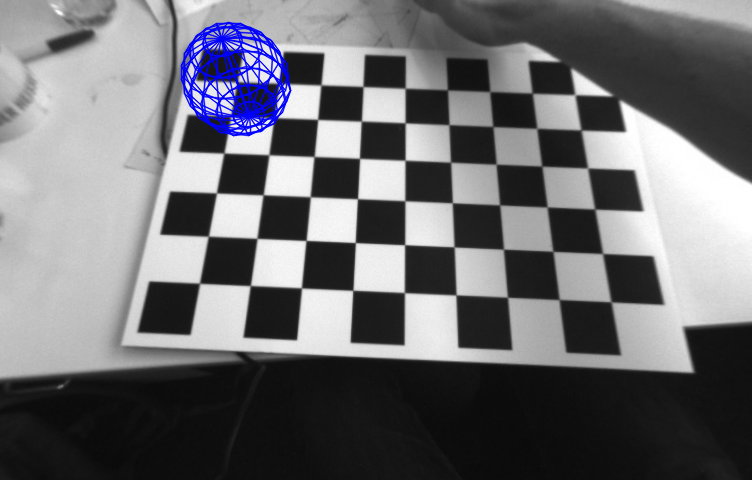

In [21]:
from tqdm.notebook import tqdm
from PIL import Image


images = []

for ii in tqdm(range(736)):
    img_index = ii + 1
    img = cv2.imread('data/images/img_{0:04d}.jpg'.format(img_index))

    # 왜곡 보정
    img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

    # 현재 프레임의 카메라 변환 행렬
    T_C_W = pose_vector_to_transformation_matrix(pose_vectors[ii, :])

    # 구의 점을 카메라 좌표계로 변환
    p_C_sphere = (T_C_W @ p_W_sphere.T).T
    p_C_sphere = p_C_sphere[:, :3]  # x, y, z만 추출

    # 이미지 좌표로 투영
    sphere_pts = project_points(p_C_sphere, K, np.zeros([4, 1]))
    sphere_pts_int = sphere_pts.astype(int)

    # 구 점 그리기 (파란색)
    for x, y in sphere_pts_int:
        if 0 <= y < img_undistorted.shape[0] and 0 <= x < img_undistorted.shape[1]:
            img_undistorted[y, x] = (0, 0, 255)
     # 선 그리기: 위도와 경도에 따른 선 연결

    # 위도 선 그리기
    for i in range(num_theta):
        for j in range(num_phi - 1):
            pt1 = sphere_pts_int[i * num_phi + j]
            pt2 = sphere_pts_int[i * num_phi + (j + 1)]
            if all(0 <= pt1) and all(pt1 < [img_undistorted.shape[1], img_undistorted.shape[0]]) and \
               all(0 <= pt2) and all(pt2 < [img_undistorted.shape[1], img_undistorted.shape[0]]):
                cv2.line(img_undistorted, tuple(pt1), tuple(pt2), (0, 0, 255), 1, cv2.LINE_AA)

    # 경도 선 그리기
    for j in range(num_phi):
        for i in range(num_theta - 1):
            pt1 = sphere_pts_int[i * num_phi + j]
            pt2 = sphere_pts_int[(i + 1) * num_phi + j]
            if all(0 <= pt1) and all(pt1 < [img_undistorted.shape[1], img_undistorted.shape[0]]) and \
               all(0 <= pt2) and all(pt2 < [img_undistorted.shape[1], img_undistorted.shape[0]]):
                cv2.line(img_undistorted, tuple(pt1), tuple(pt2), (0, 0, 255), 1, cv2.LINE_AA)


    images.append(img_undistorted)

# 마지막 프레임 확인
Image.fromarray(images[-1])

In [22]:
import warnings

# Save to video file
fps = 20
height, width, _ = images[10].shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video_filename = 'ar_wireframe_cube.avi'
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

with warnings.catch_warnings(record=True):
    for image in tqdm(images):
        video_writer.write(image)

video_writer.release()

  0%|          | 0/736 [00:00<?, ?it/s]

In [24]:
# Optionally display as animation
plot_sequence_images(np.array(images))

<Figure size 752x480 with 0 Axes>